# Computer Vision

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [21]:
import torch # библиотека машинного обучения
import torchvision # библиотека для работы с CV
from torchvision import transforms # библиотека для аугментации, а так же преобразования изображений
import tarfile # библиотека для работы загрузки и сохранения изображений в tar на диске

# Определяем объект BASE_TRANSFORM для создания последовательности преобразований для обработки изображений.
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [22]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)  # загрузка данных для обучающей модели
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) # загрузка данных для модели тестирования
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

train_loader, test_loader = load_dataloaders()
print('Количество батчей в train_loader:', len(train_loader))
print('Количество батчей в test_loader:', len(test_loader))

Files already downloaded and verified
Files already downloaded and verified
Количество батчей в train_loader: 782
Количество батчей в test_loader: 157


## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../datasets/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(images, labels, padding_size=15, labels_split_size=10): # отображение изображений и меток классов к ним
    # настройка labels_split size изменена с условия 25 на 10 для соответствия надписи и выводимой картинки
    # убрать нормализацию
    images = images / 2 + 0.5
    npimg = images.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

               cat          ship          ship          plane


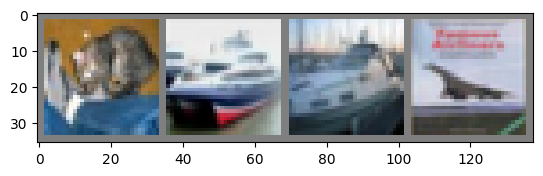

In [24]:
dataiter = iter(test_loader) # получение батча для тестовой выборки
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]), labels[:4]) # визуализация 4х картинок и 4 меток


## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../datasets/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться:
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [25]:
import torch.nn as nn # работа со слоями нейросети и для установки функций (скорость обучения, потери)
class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = nn.Conv2d(3, 32, 1)
# использование перечисленных в условии функций Conv2d,BatchNorm2d, ReLU с размером квадрата 3x3 пикселя и 32х32 размерами, слоя нормализации по батчу и функции активации ReLU
        self.residual_block = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.clf = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):

        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out

In [26]:
# базовая проверка правильности написания нейросети
net = ResidualNet()
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [1]:
class Trainer:
# инициализация нейросети с параметрами: модель train или test, оптимизатор например SGD градиентный спуск и criterion для указания функции потерь
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # подключение GPU, если драйвер устройства внешней видеокарты CUDA не загружен то вычисление проводим на ЦПУ
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)

        self.optimizer = optimizer
        self.criterion = criterion

# обучение модели обучающей train выборки, каждый проход (эпоха) возвращает значение потерь и точности
    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)
# обучение модели на заданном количестве проходов (эпох) вывод значения потерь и точности обучающей и тестовой выборки
    def train(self, train_loader, test_loader, n_epochs):

        self.train_loss_log = []
        self.train_acc_log = []
        self.test_loss_log = []
        self.test_acc_log = []

        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")
# тестирование модели на тестовой выборке и возврат значения потерь и точности
    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

In [2]:
def plot_train_log(trainer): # функция для построения графиков точностии и потерь обучающей и тестовой выборок в зависимости от количества проходов (эпох)
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [ ]:
model = ResidualNet() # создание модели
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, adam=0.9) # указание в качестве оптимизатора стохастический градиентный спуск
# lr - параметр скорости обучения модели, momentum - оптимизатор
criterion = nn.CrossEntropyLoss() # указание функцией потерь кросс-энтропии согласно условиям

In [ ]:
trainer = Trainer(model, optimizer, criterion) # обучение с подключением оптимизатора и функции потерь для каждой модели
trainer.train(train_loader, test_loader, n_epochs=11) # обучение модели на 11 проходах (эпохах)

Сеть загружена на cpu
Epoch 0
 train loss: 113.02236723351052, train acc: 0.3820532289002558
 test loss: 98.87313088338087, test acc: 0.45660828025477707

Epoch 1
 train loss: 94.74896946099713, train acc: 0.47846067774936063
 test loss: 89.38238030937826, test acc: 0.5048765923566879

Epoch 2
 train loss: 87.23298986000783, train acc: 0.5194213554987213
 test loss: 84.18972282652642, test acc: 0.527468152866242

Epoch 3
 train loss: 82.48322681514809, train acc: 0.5449968030690537
 test loss: 80.0316497778437, test acc: 0.5577229299363057

Epoch 4
 train loss: 78.72882604720952, train acc: 0.570252557544757
 test loss: 77.56196842072116, test acc: 0.5709593949044586

Epoch 5
 train loss: 75.13562363675793, train acc: 0.5906329923273658
 test loss: 74.02073049849005, test acc: 0.59265525477707

Epoch 6
 train loss: 71.85052569260073, train acc: 0.6086956521739131
 test loss: 70.07645713903342, test acc: 0.6154458598726115

Epoch 7
 train loss: 68.92339604467992, train acc: 0.6259390984

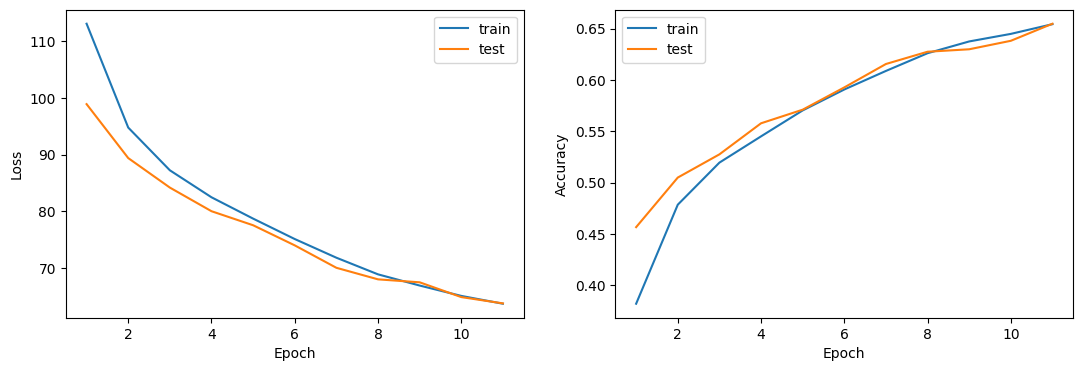

In [ ]:
plot_train_log(trainer)

## Task 5

Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет.
![sample](../datasets/images_sample.png)
![sample](../datasets/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

Files already downloaded and verified
Files already downloaded and verified
               cat          ship          ship          plane


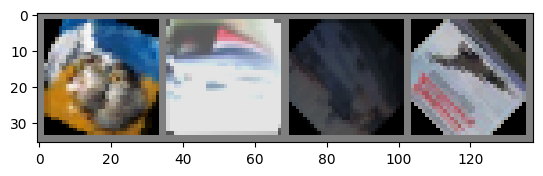

In [32]:
transform_v2 = transforms.Compose([
    transforms.RandomRotation(degrees=70), # пример аугментации поворот изображения
    transforms.ColorJitter(brightness=0.9, contrast=0.5, saturation=0.1), # пример аугментации корректировка яркости, контраста
    #transforms.RandomHorizontalFlip(p=0.5), # пример аугментации отражение изображения по горизонтали (зеркальность)
    transforms.RandomVerticalFlip(p=0.5), # пример аугментации отражение изображения по вертикали (зеркальность)
    transforms.AugMix(), # пример аугментации размывка изображения
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_v2, test_loader_v2 = load_dataloaders(transform=transform_v2) # загрузка данных после аугментации

dataiter_v2 = iter(test_loader_v2)
images_v2, labels_v2 = next(dataiter_v2)
imshow(torchvision.utils.make_grid(images_v2[:4]), labels_v2[:4])

In [30]:
model = ResidualNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, criterion)
trainer.train(train_loader_v2, test_loader_v2, n_epochs=11)

Сеть загружена на cpu
Epoch 0
 train loss: 110.72889913622376, train acc: 0.3946611253196931
 test loss: 95.3146482091041, test acc: 0.47273089171974525

Epoch 1
 train loss: 91.36583240196833, train acc: 0.4989210358056266
 test loss: 85.57925018990875, test acc: 0.5279657643312102

Epoch 2
 train loss: 84.42700828249802, train acc: 0.5387827685421995
 test loss: 81.31564035840854, test acc: 0.5480692675159236

Epoch 3
 train loss: 79.84309942338167, train acc: 0.5620004795396419
 test loss: 77.99615254979224, test acc: 0.569765127388535

Epoch 4
 train loss: 75.95353436652961, train acc: 0.5878156969309463
 test loss: 73.11324717284768, test acc: 0.596437101910828

Epoch 5
 train loss: 72.50881233971442, train acc: 0.6059382992327366
 test loss: 70.07258812485227, test acc: 0.6099721337579618

Epoch 6
 train loss: 69.65048594486987, train acc: 0.6225223785166241
 test loss: 68.52021321825161, test acc: 0.6240047770700637

Epoch 7
 train loss: 67.36355655211622, train acc: 0.634430946

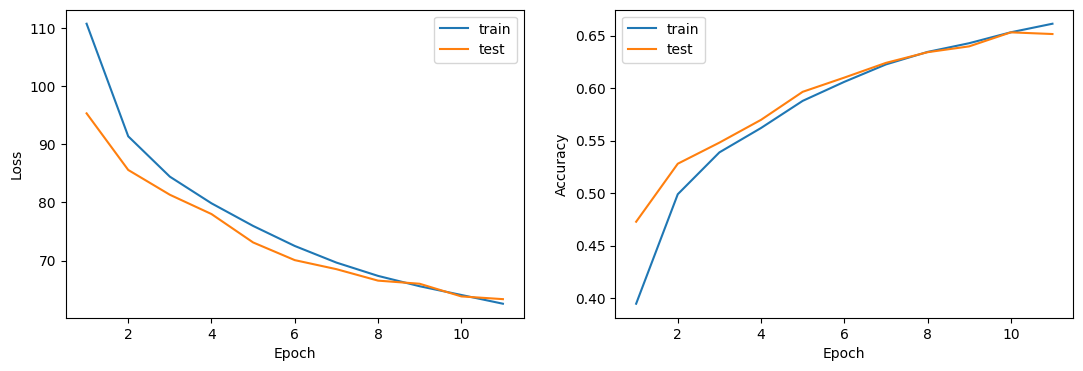

In [31]:
plot_train_log(trainer)